# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import scipy
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

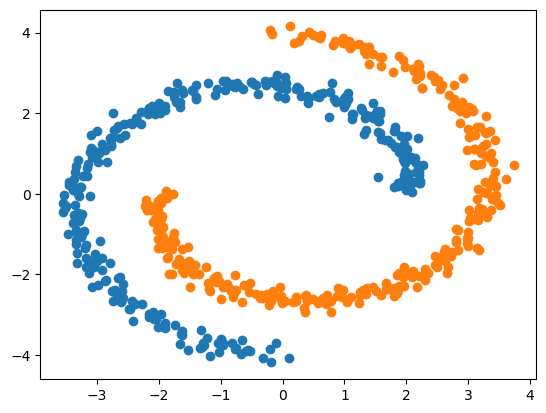

Signature: two_moons(num_samples, moon_radius=2.0, moon_var=0.02)
Docstring:
Creates two intertwined moons

:param num_samples: number of samples to create in the dataset
:param moon_radius: radius of the moons
:param moon_var:    variance of the moons
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      ~/Desktop/X/4A - 5A/MVA/S2/Graphs in ML/TPs/spectral_clustering/generate_data.py
Type:      function

In [2]:
# Example

#for fn in [worst_case_blob]:
#for fn in [point_and_circle]:
#for fn in [blobs]:
for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
two_moons?

## Building similarity graph

In [3]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0, mode =  'OR'):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph
    mode : str
        'OR' : if two nodes are connected, at least one of them will have the other as its neighbour
        'AND' : if two nodes are connected, both of them will have the other as neighbour

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.zeros((n, n))

    for i in range(n):
            for j in range(n):
                similarities[i, j] = np.exp(-np.linalg.norm(X[i] - X[j]) ** 2 / (2 * var)) * (i != j)

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = similarities * (similarities >= eps)

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        
        for i in range(n):
            neighbors = np.argsort(-similarities[i]) 
            for j in neighbors[:k]: 
                W[i, j] = similarities[i, j]
       
        if mode == 'OR':
            W = np.maximum(W, W.T)

        elif mode == 'AND':
            W = np.minimum(W, W.T)

        else:
            raise ValueError('Specify the mode')

    return W


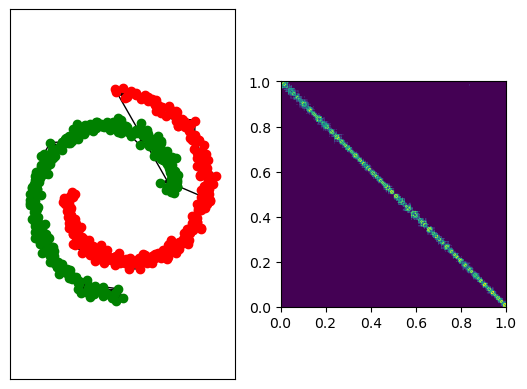

In [4]:
# Example

W = build_similarity_graph(X, k = 10)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [5]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    D = np.diag(np.sum(W, axis=1))

    if laplacian_normalization == 'unn':
        L = D - W

    elif laplacian_normalization == 'sym':
        D_sqrt = np.sqrt(D)
        D_inv = np.linalg.inv(D_sqrt)
        L = np.eye(W.shape[0]) - D_inv @ W @ D_sqrt
    
    elif laplacian_normalization == 'rw':
        D_inv = np.linalg.inv(D)
        L = np.eye(W.shape[0]) - D_inv @ W

    else : 
        raise ValueError('Invalid Laplacian normalization mode')
        
    return L

## Clustering

In [6]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    if chosen_eig_indices is not None:
        V = scipy.linalg.eigh(L)[1][:, chosen_eig_indices]

    ## Adaptive choice of eigenvectors
    ## I dont implement elbow method here, because picking the first num_classes eigenvectors is a solution that works well
        
    else : 
        eigen_values , eigenvectors = scipy.linalg.eigh(L, subset_by_index=[0, num_classes-1])
        V = eigenvectors[:, :num_classes]
    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(V)
    Y = kmeans.labels_

    return Y

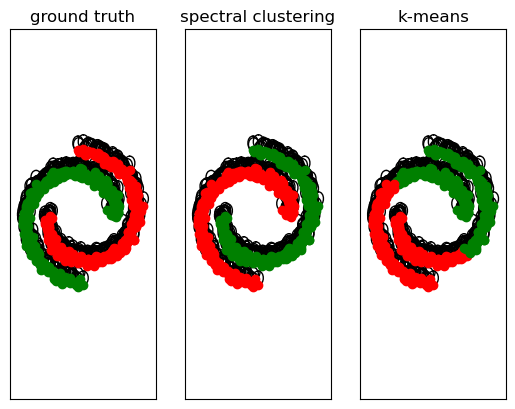

In [7]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [8]:
def parameter_sensitivity(param_type):
    """
    TO BE COMPLETED.
    
    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    parameter_type = param_type # choose between 'k' or 'eps'
    
    if parameter_type == 'k':
        parameter_candidate = [1, 2, 5, 7, 10, 12, 13, 15, 16,  17, 19, 20, 25, 30, 40, 50, 70, 100] #the number of neighbours for the graph (if 'k')
    else : 
        parameter_candidate = [0.1, 0.3, 0.5, 0.6, 0.6165950018614822, 0.62, 0.65, 0.7, 0.75, 0.8, 0.85, 0.95, 0.98, 0.985, 0.99, 0.995] #epsilon threshold (if 'eps')

    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]
    
    plt.figure()
    plt.plot(np.log(parameter_candidate)/np.log(10), parameter_performance)
    plt.xlabel(f"log({parameter_type})")
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()


## Image segmentation

In [109]:
def image_segmentation(input_img):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    print(X.shape)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    
    if input_img == 'four_elements.bmp':
        var = 1.0
        k = 70
        laplacian_normalization = 'rw'
        num_classes = 6
        W = build_similarity_graph(Xr, var=var, k=k)
        L = build_laplacian(W, laplacian_normalization)
        Y_rec = spectral_clustering(L, None, num_classes=num_classes)

    else :
        var = 0.5
        k = 5
        laplacian_normalization = 'unn'

        num_classes = 6
        W = build_similarity_graph(Xr, var=var, k=k)
        L = build_laplacian(W, laplacian_normalization)
        Y_rec = spectral_clustering(L, None, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

(50, 50, 3)


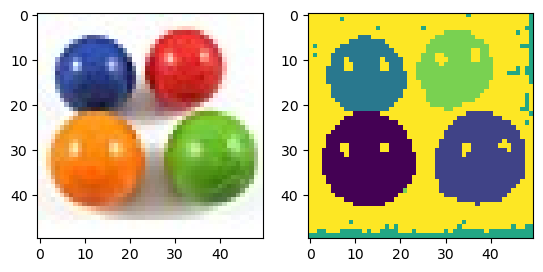

In [87]:
image_segmentation(input_img='four_elements.bmp')

(50, 50, 3)


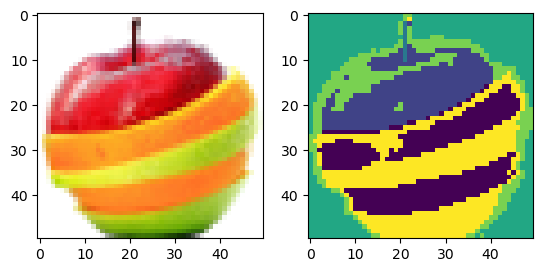

In [110]:
image_segmentation(input_img='fruit_salad.bmp')

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

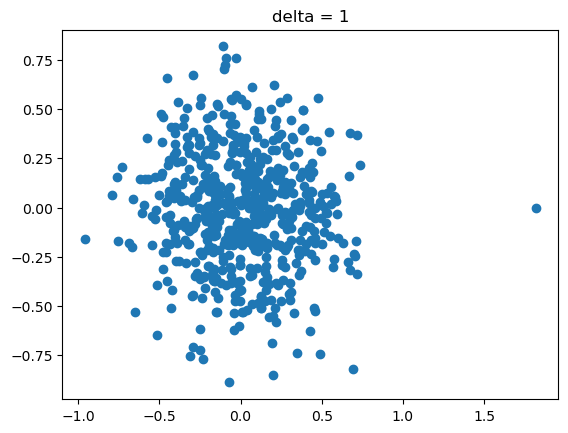

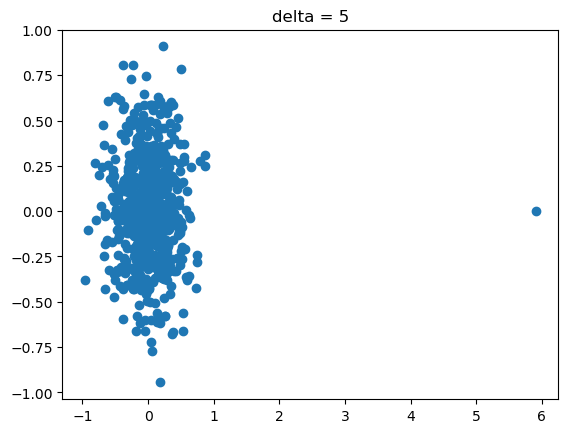

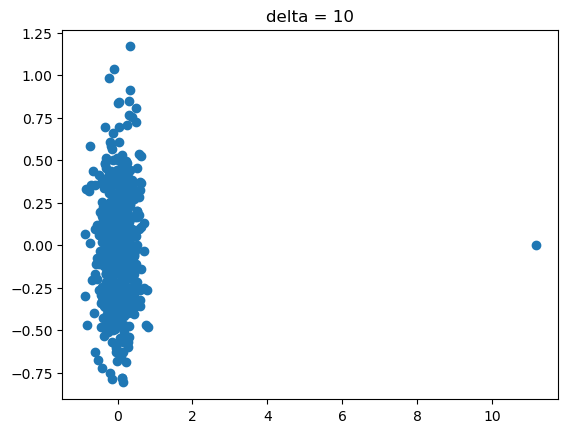

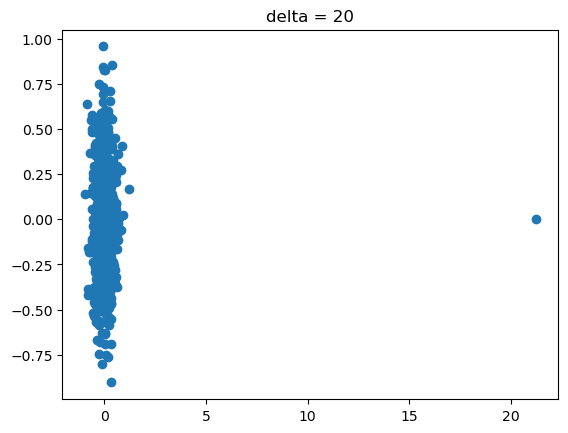

In [10]:
deltas = [1, 5, 10, 20]

for delta in deltas : 
    for fn in [worst_case_blob]: 
        X, Y = fn(num_samples=600, delta=delta)
        plot_clusters(X, Y, fignum=str(fn), title=f"delta = {delta}")
        plt.show()


Basically, delta is the distance between the main cluster and the isolated point. 

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

In [11]:
# Find the closest point to the outlier of the blob dataset
def find_epsilon(X, delta, var = 1.0):
    n = X.shape[0]
    similarities = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            similarities[i, j] = np.exp(-np.linalg.norm(X[i] - X[j]) ** 2 / (2 * var)) * (i != j)

    sum_ = np.sum(similarities, axis=1)
    outlier_index = np.argmin(sum_)
    closest_to_outlier = np.argmax(similarities[outlier_index])

    epsilon = similarities[outlier_index, closest_to_outlier]
    return epsilon

# Example : 

Text(0.5, 1.0, 'epsilon as a function of delta')

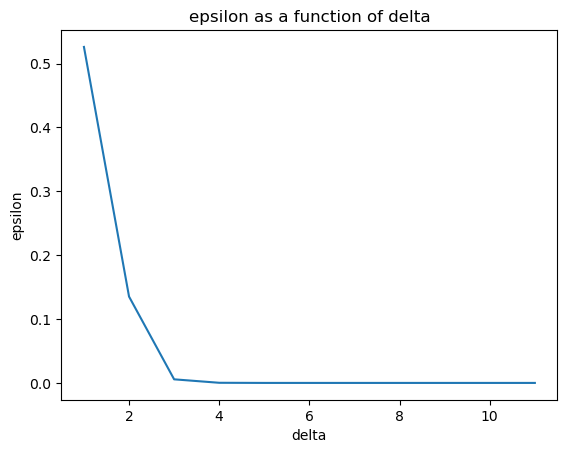

In [12]:
deltas = range(1, 12)
epsilons = []
for delta in deltas:
    X, Y = worst_case_blob(num_samples=600, delta = delta)
    epsilon = find_epsilon(X, delta)
    epsilons.append(epsilon)

plt.plot(deltas, epsilons)
plt.xlabel('delta')
plt.ylabel('epsilon')
plt.title('epsilon as a function of delta')

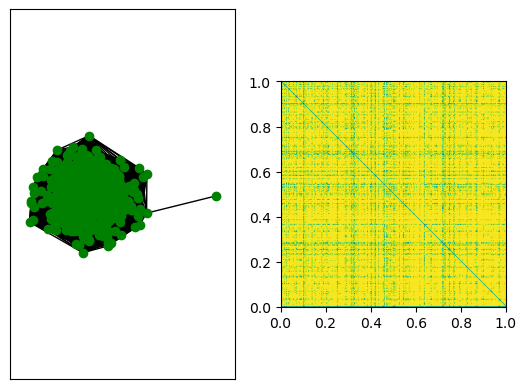

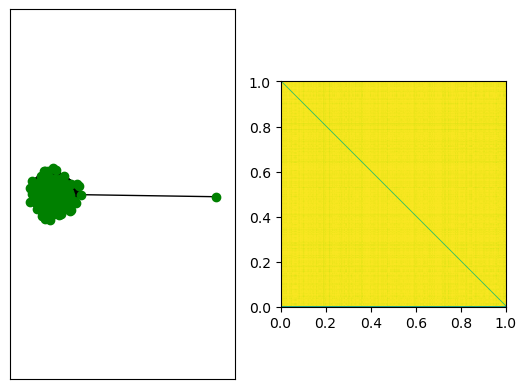

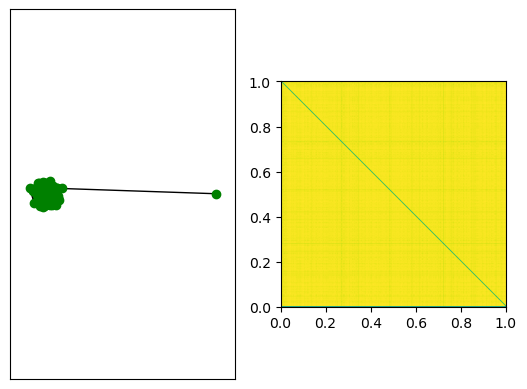

In [13]:
deltas2 = [1, 5, 10]
for delta in deltas2 : 
    X, Y = worst_case_blob(num_samples=600, delta = delta)
    epss = find_epsilon(X, delta, var = 10)
    W = build_similarity_graph(X, eps=epss, var=10)
    plot_graph_matrix(X, Y, W)

When $\delta$ augments, $\epsilon$ rapidly falls to 0, to ensure that the graph is still connected; the graph becomes overconnected, as all the vertices of the left blobs become connected between themsleves. We lose the informative structure of the graph.  

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

It is important to build conneced graphs, as they allow efficient information or resource flow across the whole network. In the worst case blob scenario, building connected graph using K-NN is trivial, as an 'OR' graph will force the outlier to be connected to the main cluster.  

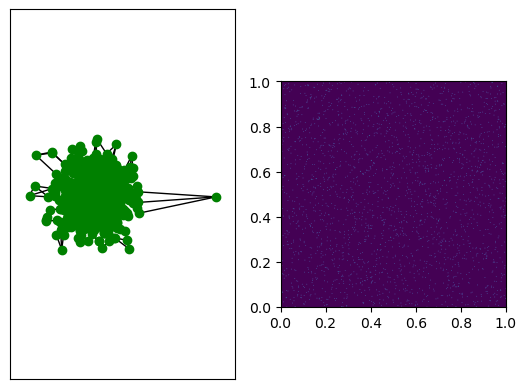

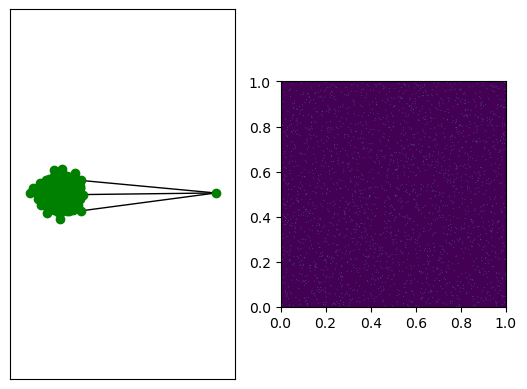

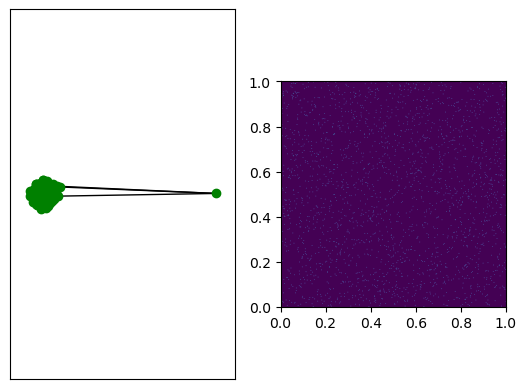

In [14]:
deltas2 = [1, 5, 10]
for delta in deltas2 : 
    X, Y = worst_case_blob(num_samples=600, delta = delta)
    W = build_similarity_graph(X, k = 3)
    plot_graph_matrix(X, Y, W)

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

The graph is connected


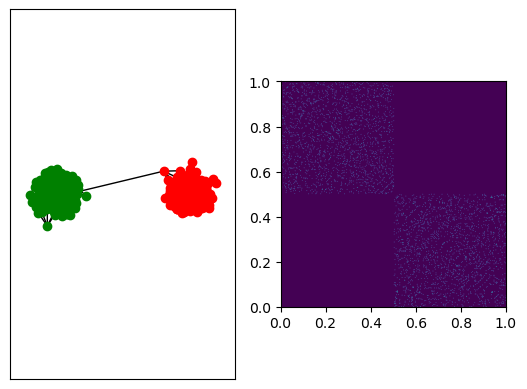

In [15]:
X, Y = blobs(num_samples=600)
W = build_similarity_graph(X, k = 5, var=5, mode='OR')

# Add an edge to make the graph connected
W[0, 599] = 1
eigen_values = scipy.linalg.eigh(build_laplacian(W))[0]
if (eigen_values[1] > 1e-5):
    print('The graph is connected') # Test the multiplicity of the eigenvalue 0
else:
    print('The graph is not connected')

plot_graph_matrix(X, Y, W)

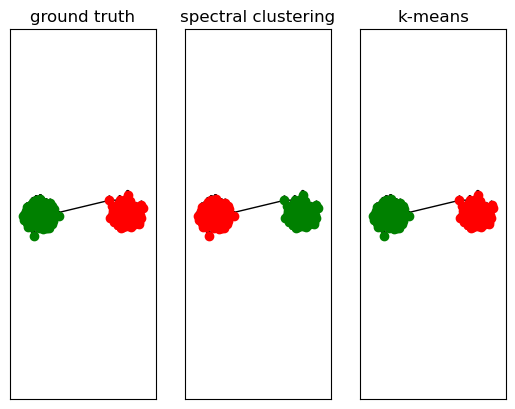

In [16]:
# We use the first 2 eigenvectors to cluster the data since we have 2 blobs
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))

I'm not enforcing any choice of eigen vectors and let the algorithm determine by itself (take the first two eigenvectors since we have two classes). In this case, the traditional K-Means performs well and manages to cluster the data. 

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

The graph is not connected


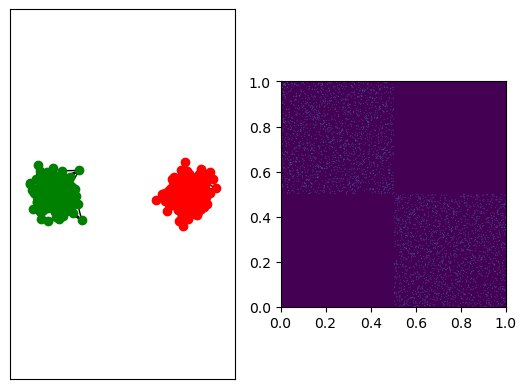

In [17]:
X, Y = blobs(num_samples=600)
W = build_similarity_graph(X, k = 5, var=5, mode='OR')

eigen_values = scipy.linalg.eigh(build_laplacian(W))[0]
if (eigen_values[1] > 1e-5):
    print('The graph is connected') # Test the multiplicity of the eigenvalue 0
else:
    print('The graph is not connected')

plot_graph_matrix(X, Y, W)

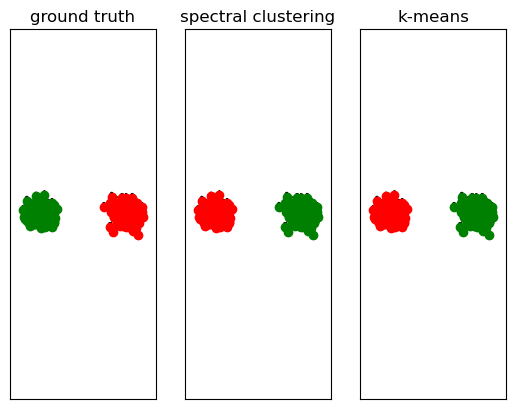

In [172]:
# We use the first 2 eigenvectors to cluster the data since we have 2 blobs
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=2)
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

Let $c$ be the number of classes that we want to identify (supposed known, since it is an argument of the function). Had $c$ not been known, we could have estimated it using the elbow method on eigenvalues for instance (decide to set $c =$ number of non nul eigenvalues), but it is not the case here. $c$ being known, we project the data on the subspace spaned by the $c$ first eigenvectors of the Laplacian matrix. We then perform k-means clustering in this subspace. 

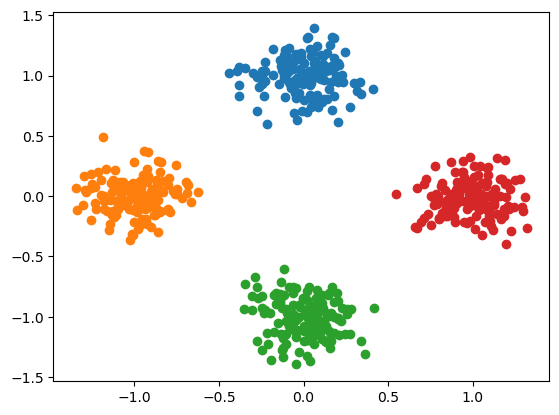

In [18]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

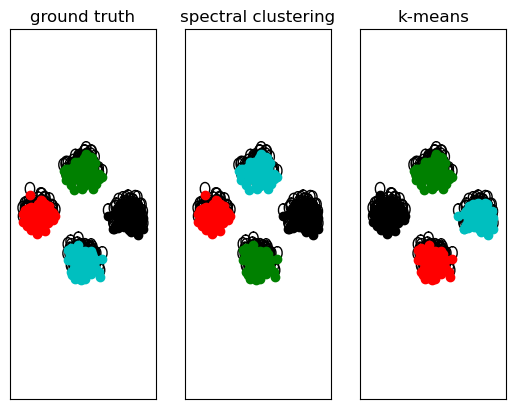

In [19]:
W = build_similarity_graph(X, k = 5, var=1, mode='OR')
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))

Let us now increase the variance of the blobs :

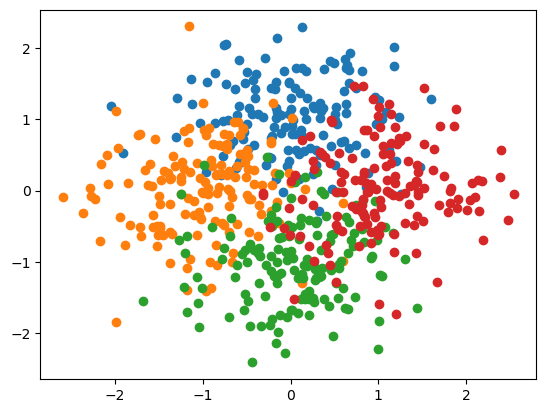

In [20]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.6)
plot_clusters(X, Y)

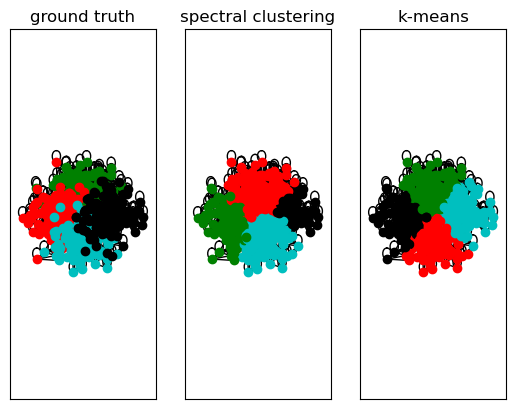

In [21]:
W = build_similarity_graph(X, k = 5, var=1, mode='OR')
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))

When the blob variances increase, the performance of the clustering dimishe. 

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

I am using k-means for the cluster assignment. It is more appropriated when we need a specific number of clusters. On the other hand, thresholding is perhaps more suited when eigenvector values show clear gaps and for binary classification. 

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

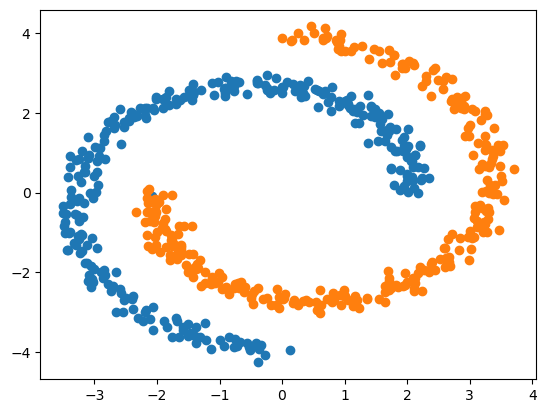

In [22]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

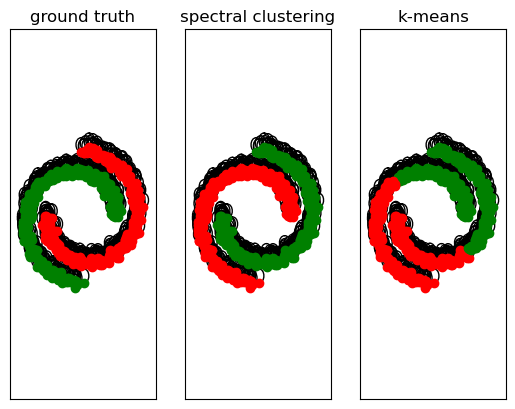

In [23]:
num_classes = 2
W = build_similarity_graph(X, k = 10)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

The graph c;ustering manages to identify the two clusters, whereas k-means fails to do so. This is because k-means is based on compactness, whereas graph clustering is based on connectivity ! The graph clustering therefore leverages the fact that the graph has 2 very connected components, something that k-means fails to take into account. 

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

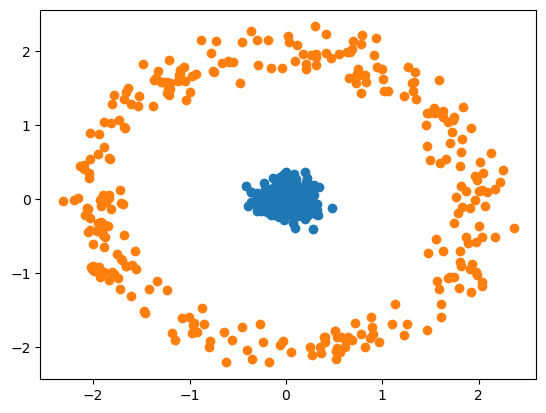

In [24]:
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

Unnormalized Laplacian


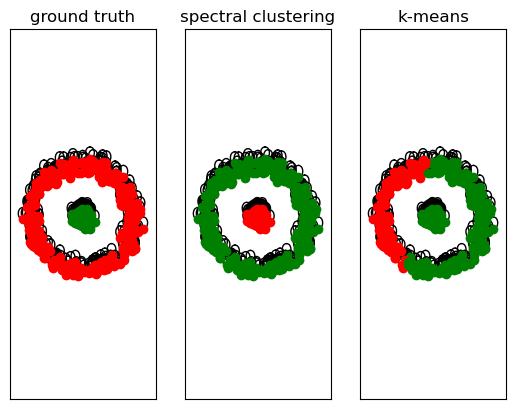

Random Walk Laplacian


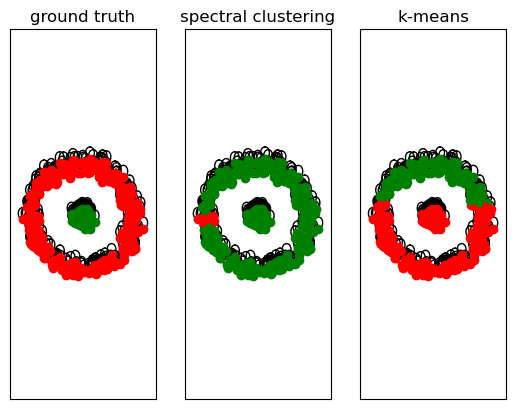

In [25]:
W = build_similarity_graph(X, k = 10, mode = 'OR')
L = build_laplacian(W)
L_rw = build_laplacian(W, laplacian_normalization='rw')

Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=2)
Y_rec_rw = spectral_clustering(L_rw, chosen_eig_indices=None, num_classes=2)

# Plot results, comparing to KMeans
print('Unnormalized Laplacian')
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))
print('Random Walk Laplacian')
plot_clustering_result(X, Y, L_rw, Y_rec_rw, KMeans(2).fit_predict(X))

The random walk normalized Laplacian clustering performs rather poorly here, failing to identify the two clusters. Hypothesis : the use of a random walk normalized Laplacian is recommended when the similarity graph has an heterogenous degree distribution. Indeed, by normalizing by $D^{-1}$, we end up looking at the probabilities of mooving from one node to another rather than the raw connections weights. Here, we have set every node's degree to 10 ; the degree distribution is very uniform ! It is therefore better to emphasize absolute connection strengths rather than relative ones ; the unnormalized Laplacian is more appropriate. 

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

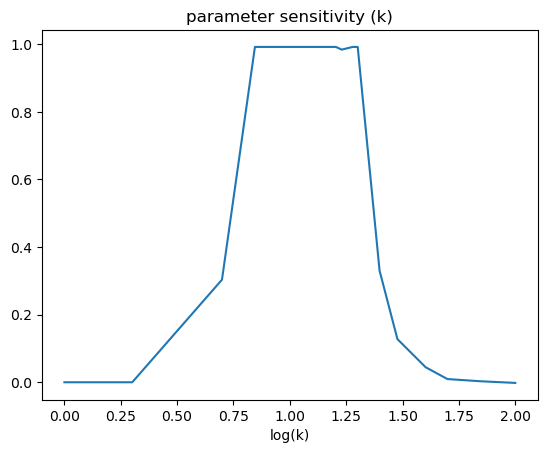

In [236]:
parameter_sensitivity('k')

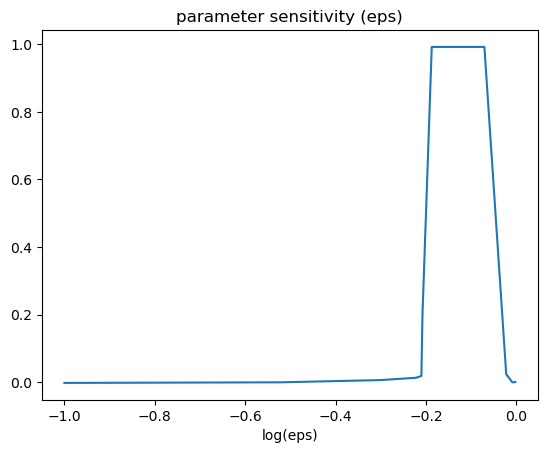

In [243]:
parameter_sensitivity('eps')

Both parameters need optimal tuning for effective clustering:

k (number of neighbors):
- Too small → insufficient connectivity, clustering fails
- Too large → excessive connectivity, loss of structure 
- Optimal value depends on dataset size

$\epsilon$ (distance threshold):
- Too small → too many edges, overconnected
- Too large → too few edges, underconnected
- Optimal value balances connectivity

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

Without ground truth labels, we cannot use precision or recall to evaluate the clustering performances. 
We can however use special metrics, used in graph-based clustering : modularity, conductance, coverage and internal density. 

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

I am using different parameters for the two images. 

1 - For the four_elements.bmp image, I try to identify 6 classes : the 4 balls, the white background and the shaded / darker tone due to the balls' shadows (6 classes in total). 
- I build a similarity matrix using k-NN **with a high number of neighbors**, k = 70. I tried to use a smaller number of neighbors, but the results were very poor. I guess that with a small number k, the graph does not sufficiently approximates the underlying data geometric structure. 
- When computing the Laplacian, I use a random walk normalization (heuristic search, I tried unn and sym normalization but the rw yields better results). 
- I finaly perform spectral clustering with these parameters. 

2 - For the fruit_salad.bmp image, I also try to identify 6 classes : green apple, orange, lighted red apple, shaded red apple, white background and the apple's stem.
- I build a similarity matrix using k-NN **with a small number of neighbors**, k = 6. If i take a more important k, the apple's contours get blured and the segmentation fails to identify the stem. 
- When computing the Laplacian, I dont use normalization (heuristic search, I tried rw and sym normalization but the unn yields better results)
- I modify the variance and set it to 0.5
- I finaly perform spectral clustering with these parameters. 

(50, 50, 3)


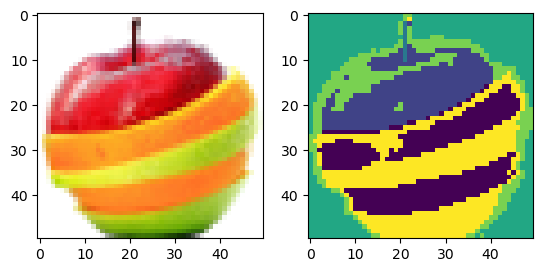

In [111]:
image_segmentation('fruit_salad.bmp')

(50, 50, 3)


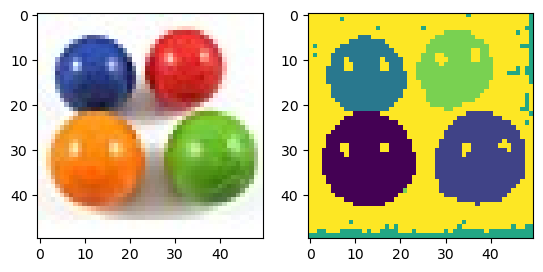

In [88]:
image_segmentation('four_elements.bmp')

Failure : if we dont use enough neighbours for the four_balls and too many neighbors for the fruit_salad, without changing the other parameters : 

In [113]:
def failed_image_segmentation(input_img):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    print(X.shape)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    
    if input_img == 'fruit_salad.bmp':
        var = 1.0
        k = 70
        laplacian_normalization = 'rw'
        num_classes = 6
        W = build_similarity_graph(Xr, var=var, k=k)
        L = build_laplacian(W, laplacian_normalization)
        Y_rec = spectral_clustering(L, None, num_classes=num_classes)

    else :
        var = 0.5
        k = 5
        laplacian_normalization = 'unn'

        num_classes = 6
        W = build_similarity_graph(Xr, var=var, k=k)
        L = build_laplacian(W, laplacian_normalization)
        Y_rec = spectral_clustering(L, None, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

(50, 50, 3)


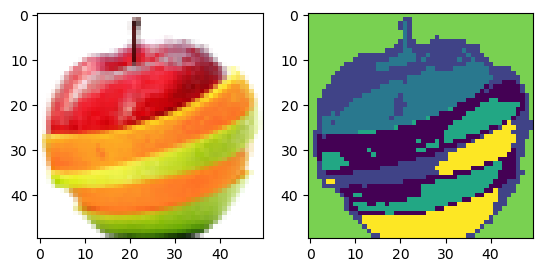

In [115]:
failed_image_segmentation('fruit_salad.bmp')

(50, 50, 3)


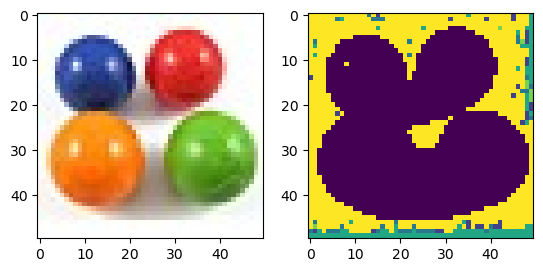

In [116]:
failed_image_segmentation('four_elements.bmp')

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

To reduce the computational and occupational cost of spectral clustering for large-scale images, we could : 

- Compute the eigenvalues decomposition of a subset of the similarities graph's columns. Eigenvectors of the total graph could therefore be qpproximated using the eigen vectors of this smaller matrix. We would have to identify representative pixel regions of the original image to do so. 

- Try to force the Laplacian matrix to be as sparse as possible. 

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

In [117]:
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.io import imread

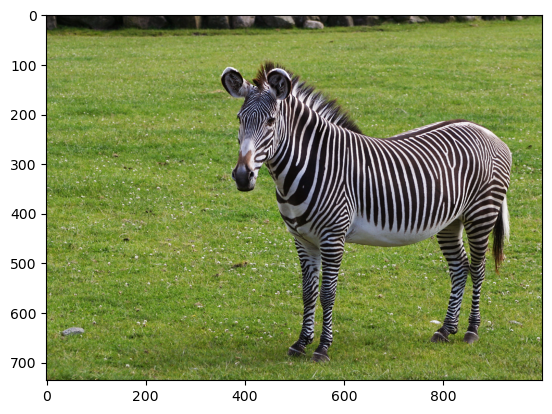

In [122]:
image = imread('Grevys_zebra.jpg')
plt.imshow(image)

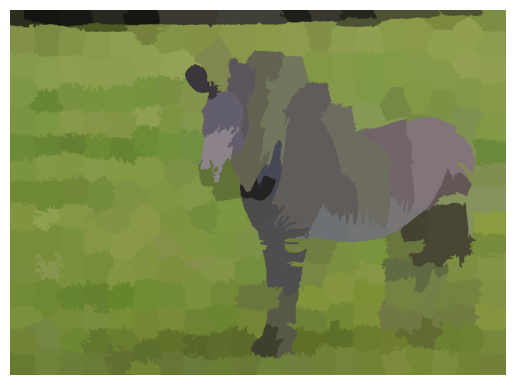

In [132]:
segments = slic(image, n_segments=300, compactness=20, start_label=1)
superpixel_image = label2rgb(segments, image, kind='avg')

plt.imshow(superpixel_image)
plt.axis('off')
plt.show()

# save the image
io.imsave('superpixels_zebra.jpg', superpixel_image)

In [142]:
def image_segmentation_bis(input_img):
    """
    Function to perform image segmentation on large images efficiently using SLIC superpixels.
    
    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    X = io.imread(input_img)
    print("Original Image Shape:", X.shape)
    
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    im_side = np.size(X, 1)
    
    n_segments = 200  # Tune this based on image size
    compactness = 10  # Higher values favor more spatially compact superpixels
    segments = slic(X, n_segments=n_segments, compactness=compactness, start_label=1)
    
    Xr = np.array([X[segments == label].mean(axis=0) for label in np.unique(segments)])
    print(f"Number of superpixels: {len(Xr)}")
    
    var = 1.0
    k = 5
    laplacian_normalization = 'unn'
    num_classes = 2
    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, None, num_classes=num_classes)

    label_map = np.zeros_like(segments)
    for idx, label in enumerate(Y_rec):
        label_map[segments == idx] = label

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(label_map, cmap='tab20')
    plt.title("Segmented Image")

    plt.show()

Original Image Shape: (736, 1000, 3)
Number of superpixels: 95


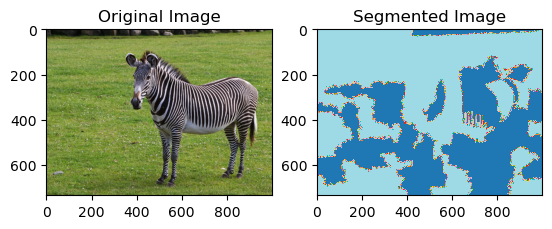

In [143]:
image_segmentation_bis('Grevys_zebra.jpg')